In [2]:
!pip install shapely

     |████████████████████████████████| 1.0 MB 12.7 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [6]:
import cv2
from tqdm.notebook import tqdm
from metrics import * 
import glob
import os
# Usage:
# evaluate(predictions, ground_truths, findBoundingBoxs=findBoundingboxs, threshold=0.5, iou_threshold=0.5):
"""
Given predictions and ground truths, calculate AP, Precision and Recall.
:param predictions: An array of prediction images.
:param ground_truths: An array of ground truth images.
:param findBoundingBoxes: A method that takes in an image, and return 
                          its bounding boxes and their corresponding confidence scores.
:param threshold: Convert image to a binary image using this threshold.
:param iou_threshold: IOU threshold for classifying a True Positive.
:return AP, precision, recall, and calculation table of dataset.
"""
pass
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
threshold=0.5
iou_threshold=0.5

total_num_GT = 0
all_data = {"confidenceScore": [], "iou": []}
all_amazon_json = glob.glob("/home/ec2-user/SageMaker/benchmarks/amazon_images/all/*.json")
for i, filename in tqdm(enumerate(all_amazon_json), total=len(all_amazon_json)):
    with open(filename,) as f:
        gt = json.load(f)
    bbs_truth = [shape['points'] for shape in gt['shapes']]
    img_name = os.path.basename(filename)[:-4] + 'jpg'
    loadpath = "./amazon_test/"+img_name
    img = cv2.imread(loadpath)
    if img is None:
        continue

    prediction = (normalize_to_gray(img) > threshold).astype(np.uint8)
    # find bounding boxes
    bbs_pred, confidences = findBoundingboxs(prediction)
        
    for bb_truth in bbs_truth:
        max_iou = 0
        max_cs = 0
        for i in range(len(bbs_pred)):
            curr_iou = iou(bbs_pred[i], bb_truth)
            if curr_iou > max_iou:
                max_iou = curr_iou
                max_cs = confidences[i]
        all_data["iou"].append(max_iou)
        all_data["confidenceScore"].append(max_cs)

    # increment total ground truths count
    total_num_GT += len(bbs_truth)

/home/ec2-user/SageMaker/benchmarks/Mask_RCNN/samples/barcode/metrics.py:74: RuntimeWarning: invalid value encountered in true_divide
  return im / im.max()
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater


At IOU 90.0
AP: 0.0
Precision: 0.0
Recall: 0.0


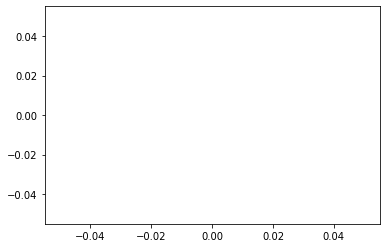

In [19]:
data = pd.DataFrame(all_data)
threshold=0.5
iou_threshold=0.9
data['total_num_GT'] = total_num_GT
data["TP"] = (data["iou"] >= iou_threshold) * 1
data["FP"] = (data["iou"] < iou_threshold) * 1
data = data.sort_values(by=["confidenceScore"], ascending=[False])
data["Acc TP"] = np.cumsum(data["TP"])
data["Acc FP"] = np.cumsum(data["FP"])
data["Precision"] = data["Acc TP"] / (data["Acc TP"] + data["Acc FP"])
data["Recall"] = data["Acc TP"] / data['total_num_GT']
plt.plot(list(data["Recall"]), list(data["Precision"]))
interpolation = list(data["Precision"])
for i in reversed(range(len(interpolation) - 1)):
    if interpolation[i+1]>interpolation[i]:
        interpolation[i]=interpolation[i+1]
plt.plot(list(data["Recall"]), interpolation)
AP = metrics.auc(list(data["Recall"]), interpolation)
precision = max(list(data["Precision"]))
recall = max(list(data["Recall"]))
print("At IOU", iou_threshold * 100)
print("AP:", AP)
print("Precision:", precision)
print("Recall:", recall)

In [18]:
data

,confidenceScore,iou,total_num_GT,TP,FP,Acc TP,Acc FP,Precision,Recall
23,0.875474,0.508709,48,1,0,1,0,1.000000,0.020833
27,0.874131,0.003931,48,0,1,1,1,0.500000,0.020833
16,0.869146,0.237704,48,0,1,1,2,0.333333,0.020833
40,0.862570,0.352963,48,0,1,1,3,0.250000,0.020833
9,0.848481,0.499702,48,0,1,1,4,0.200000,0.020833
10,0.843357,0.735841,48,1,0,2,4,0.333333,0.041667
5,0.841170,0.487866,48,0,1,2,5,0.285714,0.041667
24,0.840079,0.325806,48,0,1,2,6,0.250000,0.041667
11,0.822550,0.544760,48,1,0,3,6,0.333333,0.062500
32,0.813738,0.125978,48,0,1,3,7,0.300000,0.062500


In [4]:
len(glob.glob("/home/ec2-user/SageMaker/benchmarks/amazon_images/all/*.json"))

41

In [16]:
import pickle
with open("amazon_eval.pickle", "wb") as f:
    pickle.dump(data, f)